<a href="https://colab.research.google.com/github/MikolajKasprzyk/passengers_forecast/blob/main/passengers_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima

import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.6 MB/s eta 0:00:00


In [3]:
path_in = '/content/drive/MyDrive/Colab Notebooks/passengers_forecast/'
path_out ='/content/drive/MyDrive/Colab Notebooks/passengers_forecast/viz_files'
passengers_data = pd.read_csv(path_in + 'passengers.csv')

In [4]:
passengers_data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
passengers_data.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [7]:
passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
passengers_data['date'] = pd.to_datetime(passengers_data['Month'])
passengers_data = passengers_data.drop(['Month'], axis = 1).rename(columns={'#Passengers': 'passengers'})
passengers_data.set_index('date', inplace=True, drop=True)
passengers_data.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [9]:
# check duration of time in dataset
min_date = min(passengers_data.index)
max_date = max(passengers_data.index)
print('start date:', min_date.strftime('%Y-%m-%d'))
print('end date:', max_date.strftime('%Y-%m-%d'))

start date: 1949-01-01
end date: 1960-12-01


In [10]:
def test_stationarity(data, variable, title='Value, Mean, Std'):
    data = data.copy()
    data['roll_mean'] = data[variable].rolling(window=12).mean()
    data['roll_std'] = data[variable].rolling(window=12).std()

    plt.subplots(figsize=(14, 6))
    sns.lineplot(data=data, x =data.index, y=variable, label='Value', )
    sns.lineplot(data=data, x=data.index, y='roll_mean', label='Mean')
    sns.lineplot(data=data, x=data.index, y='roll_std', label='Standard Deviation')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=90, fontsize=10)
    plt.title(title)
    plt.show()

    # Adfuller test
    adf_result = adfuller(data[variable])
    adf_statistic = adf_result[0]
    adf_p_value = adf_result[1]
    # Print the results
    print ('Results of ADF Test:')
    print(f'ADF Statistic: {adf_statistic:.3f}')
    print(f'p-value: {adf_p_value:.3f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'{key}: {value:.3f}')

    print('\n')

    kpss_result = kpss(data[variable], regression='c', nlags='auto')
    kpss_statistic = kpss_result[0]
    kpss_p_value = kpss_result[1]
    kpss_lags_used = kpss_result[2]
    print ('Results of KPSS Test:')
    print(f'KPSS Statistic: {kpss_statistic:.3f}')
    print(f'p-value: {kpss_p_value:.3f}')
    print(f'#Lags Used: {kpss_lags_used:.3f}')
    print('Critical Values:')
    # list from kpss_result with reversed order just to keep same order as ADF
    for key,value in list(kpss_result[3].items())[::-1]:
        print(f'{key}: {value:.3f}')

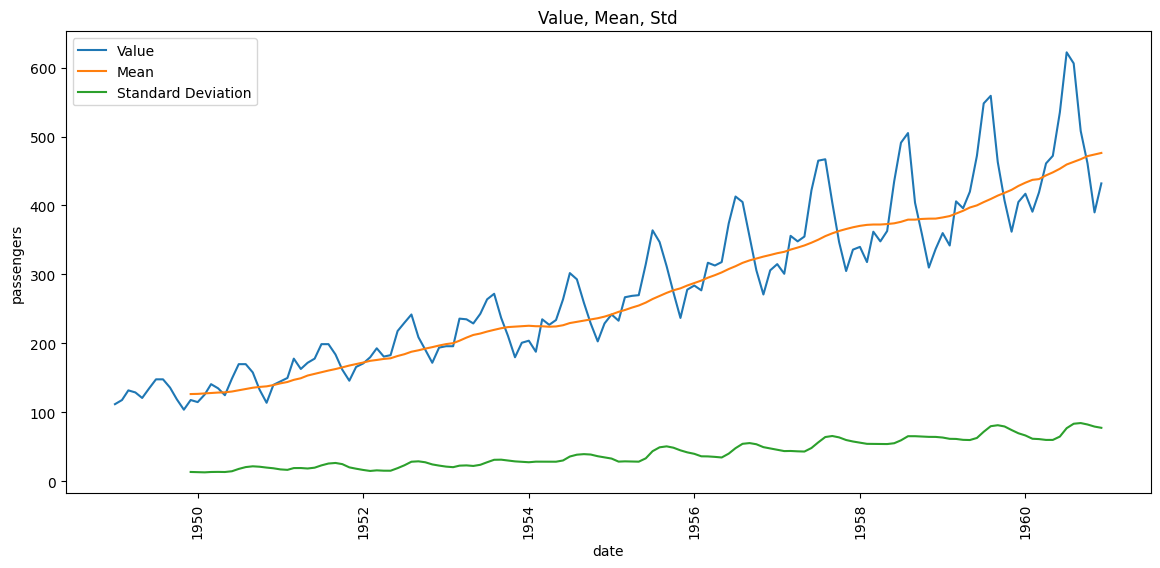

Results of ADF Test:
ADF Statistic: 0.815
p-value: 0.992
Critical Values:
1%: -3.482
5%: -2.884
10%: -2.579


Results of KPSS Test:
KPSS Statistic: 1.651
p-value: 0.010
#Lags Used: 8.000
Critical Values:
1%: 0.739
2.5%: 0.574
5%: 0.463
10%: 0.347


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [11]:
# do not look stationary, booth variance and mean differs in time
test_stationarity(passengers_data, 'passengers')

In [12]:
# make copy of original databease
passengers = passengers_data.copy()
# we can use difference month to month
passengers['passengers_diff'] = passengers['passengers'].diff()
passengers = passengers.dropna()

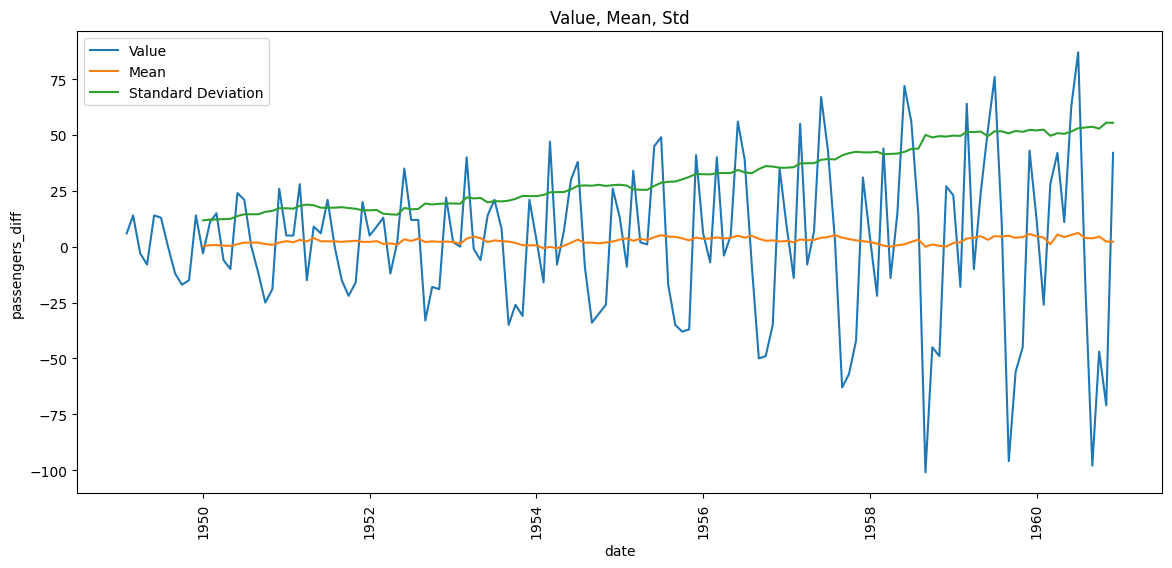

Results of ADF Test:
ADF Statistic: -2.829
p-value: 0.054
Critical Values:
1%: -3.482
5%: -2.884
10%: -2.579


Results of KPSS Test:
KPSS Statistic: 0.024
p-value: 0.100
#Lags Used: 7.000
Critical Values:
1%: 0.739
2.5%: 0.574
5%: 0.463
10%: 0.347


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [13]:
# mean is equal through time, variance is not
test_stationarity(passengers, 'passengers_diff')

In [14]:
# to make variance more stable we can use log
passengers['passengers_log'] = np.log(passengers['passengers'])
passengers.head()

,passengers,passengers_diff,passengers_log
date,,,
1949-02-01,118,6.0,4.770685
1949-03-01,132,14.0,4.882802
1949-04-01,129,-3.0,4.859812
1949-05-01,121,-8.0,4.795791
1949-06-01,135,14.0,4.905275


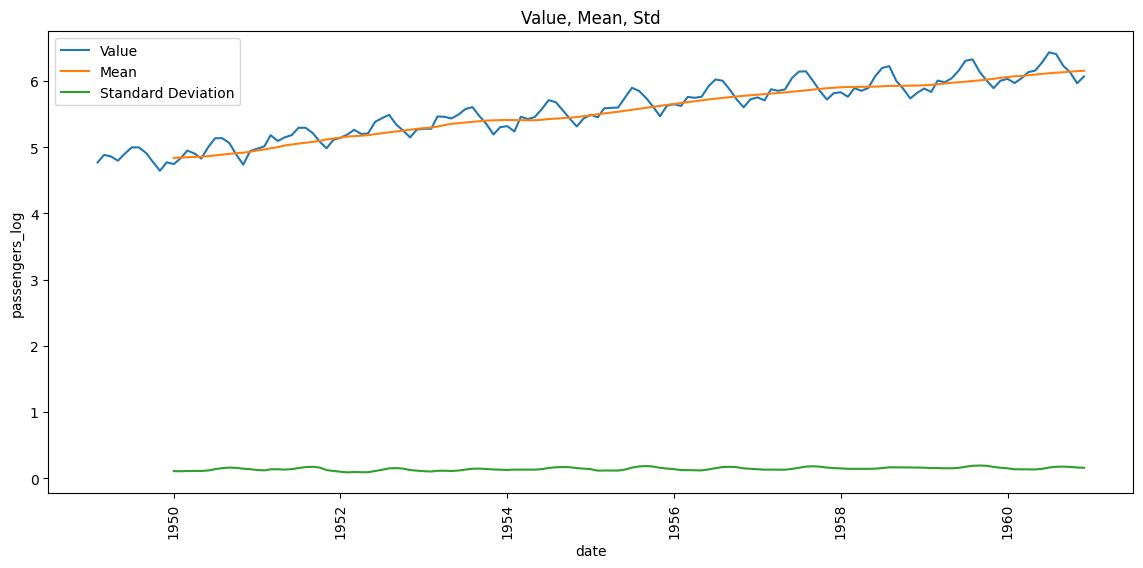

Results of ADF Test:
ADF Statistic: -1.729
p-value: 0.416
Critical Values:
1%: -3.482
5%: -2.884
10%: -2.579


Results of KPSS Test:
KPSS Statistic: 1.653
p-value: 0.010
#Lags Used: 8.000
Critical Values:
1%: 0.739
2.5%: 0.574
5%: 0.463
10%: 0.347


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [15]:
# variance is equal, mean differs through time
test_stationarity(passengers, 'passengers_log')

In [16]:
# difference month to month on log values
passengers['passengers_log_diff_1'] = passengers['passengers_log'].diff()
passengers = passengers.dropna()
passengers.head()

,passengers,passengers_diff,passengers_log,passengers_log_diff_1
date,,,,
1949-03-01,132,14.0,4.882802,0.112117
1949-04-01,129,-3.0,4.859812,-0.022990
1949-05-01,121,-8.0,4.795791,-0.064022
1949-06-01,135,14.0,4.905275,0.109484
1949-07-01,148,13.0,4.997212,0.091937


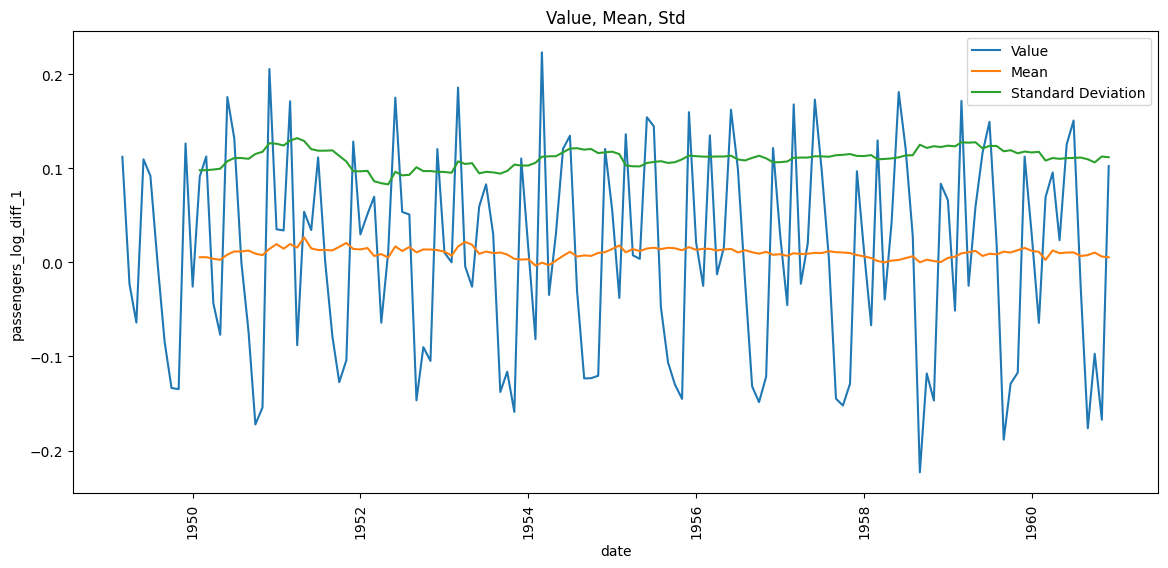

Results of ADF Test:
ADF Statistic: -2.877
p-value: 0.048
Critical Values:
1%: -3.483
5%: -2.885
10%: -2.579


Results of KPSS Test:
KPSS Statistic: 0.034
p-value: 0.100
#Lags Used: 6.000
Critical Values:
1%: 0.739
2.5%: 0.574
5%: 0.463
10%: 0.347


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [17]:
# data with log and difference of 1 looks stationary
test_stationarity(passengers, 'passengers_log_diff_1')

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


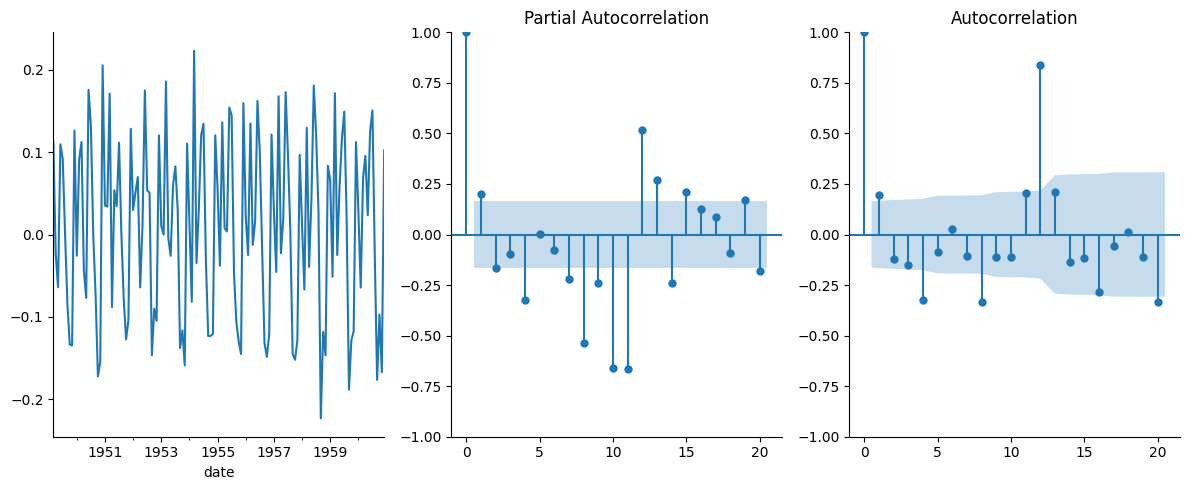

In [18]:
# plot ACF and PACF
def plot_data_acf_pacf(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    pacf = plt.subplot2grid(layout, (0, 1))
    acf  = plt.subplot2grid(layout, (0, 2))

    data.plot(ax=raw, figsize=(12, 5))
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    sns.despine()
    plt.tight_layout()

plot_data_acf_pacf(passengers['passengers_log_diff_1'], lags=20);

#Building SARIMAX model

In [19]:
# function to get scores of model, used when fitting model
def get_scores(data, col_name):
    model_scores = {}
    rmse = np.sqrt(mean_squared_error(data.dropna()[col_name],
                                      data.dropna()['prediction']))
    mae = mean_absolute_error(data.dropna()[col_name],
                              data.dropna()['prediction'])
    r2 = r2_score(data.dropna()[col_name], data.dropna()['prediction'])
    model_scores['ARIMA'] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [20]:
# prepare data for model
sarimax_data = passengers[['passengers_log']].copy()
# split data for training and testing
train = sarimax_data[:round(len(sarimax_data)*70/100)]
test = sarimax_data[round(len(sarimax_data)*70/100):]
# get (p,d,q) and (P,D,Q)m values for the model, ACF and PACF was not conclusive
arima_model_auto = auto_arima(train['passengers_log'], seasonal=True,
                              m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-233.973, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-301.792, Time=1.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-287.586, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-82.323, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-284.919, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-306.373, Time=2.11 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-248.914, Time=0.79 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-307.842, Time=1.52 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-305.161, Time=0.72 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=-3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE: 0.08023185599616227
MAE: 0.07003658956670059
R2 Score: 0.7921053004374647
None


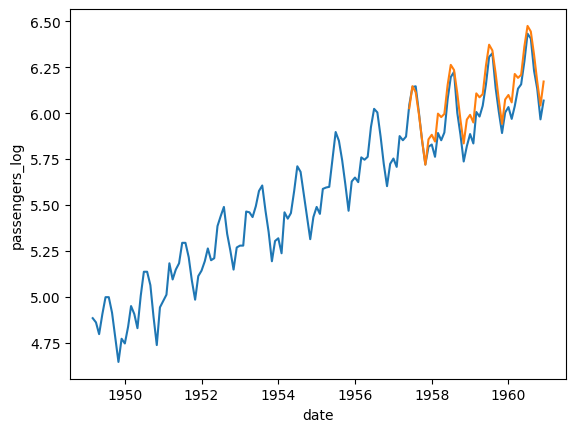

In [21]:
# built SARIMAX model using vlaues from above cell as staring point and tune it
sar_model = SARIMAX(train['passengers_log'], order = (2, 1 , 0),
                    seasonal_order=(1, 1, 0, 12),trend='t').fit()
sarimax_data['prediction'] = sar_model.predict(start=test.index[0],
                                               end=test.index[-1])
#plot predicted values on top of test values
sns.lineplot(data = sarimax_data, x=sarimax_data.index, y='passengers_log')
sns.lineplot(data = sarimax_data, x=sarimax_data.index, y='prediction')
print(get_scores(sarimax_data, 'passengers_log'))

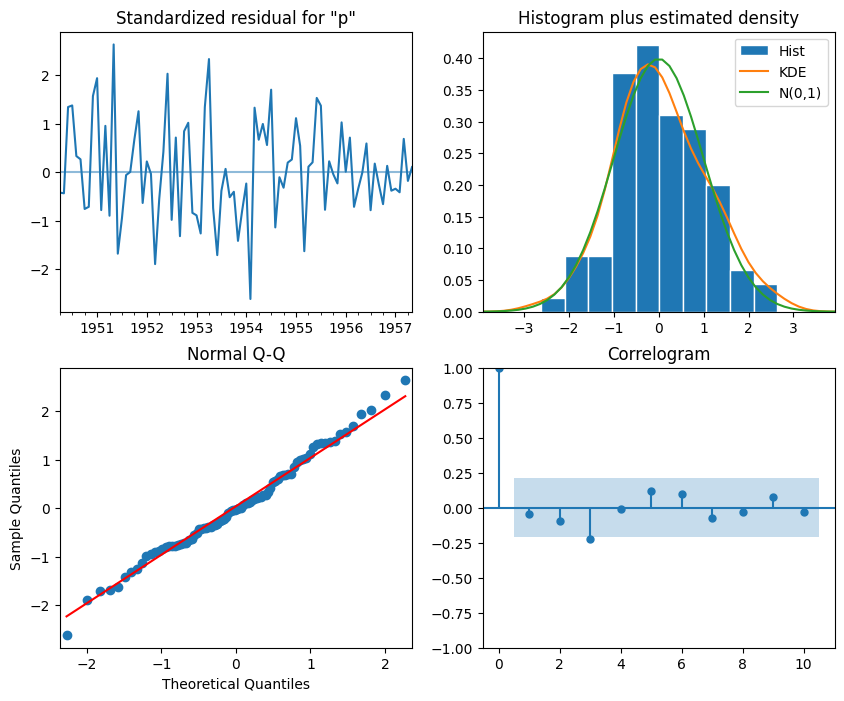

In [22]:
# diagnostics
sar_model.plot_diagnostics(figsize=(10, 8));

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='date', ylabel='passengers'>

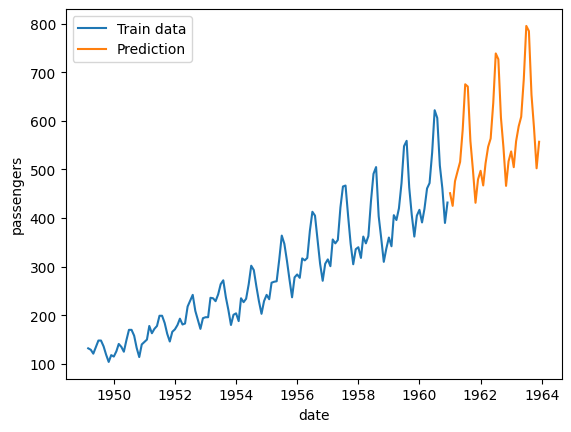

In [23]:
# prepare df for future prediction
future_dates = pd.date_range(start='1961-01-01', end='1963-12-01', freq='MS')
future_df = pd.DataFrame(index=future_dates)
# train model with all of avielable data
sar_model_full = SARIMAX(passengers['passengers_log'], order = (2, 1 , 0),
                         seasonal_order=(1, 1, 0, 12), trend='t').fit()
future_df['prediction_log'] = sar_model_full.predict(start=future_df.index[0],
                                                     end=future_df.index[-1])
# all predictions was made on log values, so now we need to go back
future_df['prediction'] = np.exp(future_df['prediction_log'])
# plot predicted values with train values
sns.lineplot(data = passengers, x=passengers.index, y='passengers',
             label='Train data')
sns.lineplot(data = future_df, x=future_df.index, y='prediction',
             label='Prediction')